In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "1"
import sys
import copy
import numpy as np
import pandas as pd
import sklearn
from sklearn import cluster, datasets, mixture
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier
from sklearn import preprocessing
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import ListedColormap
import matplotlib.colors as mcolors
import seaborn as sns
from ExKMC.Tree import Tree as ExTree
from graphviz import Source
#from scikit_obliquetree.HHCART import HouseHolderCART
#from scikit_obliquetree.segmentor import MSE, MeanSegmentor

sys.path.append("../main")
from tree import *
from rules import *
from tree_rules import *
from rule_clustering import *
from utils import *

%load_ext autoreload
%autoreload 2

In [2]:
# NOTE: The following is important for recreating results, 
# But can be changed for randomized analysis.
seed = 170
np.random.seed(seed)

In [3]:
plt.rcParams.update({
    "pgf.texsystem": "pdflatex",
    "font.family": "serif",
    "font.serif": [],
    "text.usetex": True,
    "pgf.rcfonts": False,
    "font.size": 12
})

colorblind_palette = sns.color_palette("colorblind", as_cmap=False)
cmap = ListedColormap(colorblind_palette)
subset_colors = [cmap(0), cmap(4), cmap(9)]
cmap_subset = ListedColormap(subset_colors)

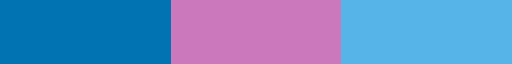

In [4]:
cmap_subset

## Simple Dataset

In [5]:
n = 2000
m = 2
k = 3

random_state = 170
data, labels = datasets.make_blobs(
    n_samples=n, cluster_std=[1.0, 2.5, 0.5], random_state=seed
)
data = preprocessing.MinMaxScaler().fit_transform(data)

Text(0, 0.5, 'y')

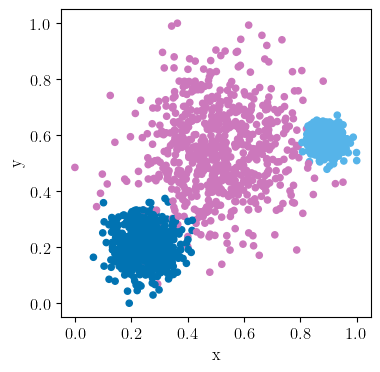

In [6]:
fig,ax = plt.subplots(figsize = (4,4), dpi = 100)
ax.scatter(data[:,0], data[:,1], c = labels, cmap = cmap_subset, alpha = 1, s = 20)
ax.set_xlabel('x')
ax.set_ylabel('y')
#plt.savefig('figures/example_ground_truth.jpg', bbox_inches = 'tight', dpi = 300)

In [65]:
point = data[10,:]
slope = point

# Direction
weights = np.array([slope[1], -slope[0]])
threshold = slope[1]*point[0] - slope[0]*point[1]

# perpedicular 
perp_weights = point
perp_threshold = point[0]**2 + point[1]**2

line = (threshold - weights[0]*np.linspace(0,1,10))/weights[1]
perp_line = (perp_threshold - perp_weights[0]*np.linspace(0,1,10))/perp_weights[1]

In [62]:
unit_vec = point/np.linalg.norm(point)
point_threshold = np.dot(unit_vec, point)

In [63]:
left_mask = np.dot(data, unit_vec) <= point_threshold
right_mask = ~left_mask

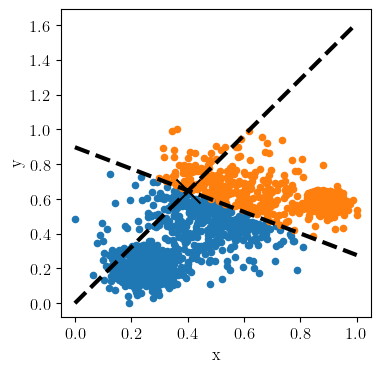

In [66]:
fig,ax = plt.subplots(figsize = (4,4), dpi = 100)
ax.scatter(data[left_mask,0], data[left_mask,1], s = 20)
ax.scatter(data[right_mask,0], data[right_mask,1], s = 20)
ax.plot(np.linspace(0,1,10), line, c = 'k', linestyle = '--', linewidth = 3)
ax.plot(np.linspace(0,1,10), perp_line, c = 'k', linestyle = '--', linewidth = 3)
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.scatter(point[0], point[1], marker = 'x', s = 300, c = 'k')

### Kmeans baseline

In [7]:
kmeans = KMeans(n_clusters=k, random_state=seed).fit(data)
kmeans_clustering = labels_to_clustering(kmeans.labels_)
cost = kmeans_cost(data, kmeans_clustering, kmeans.cluster_centers_)

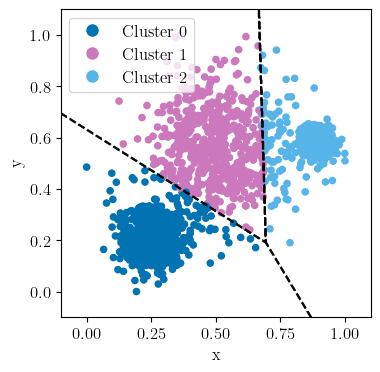

In [8]:
colorswitch = {0:2, 1:0, 2:1}
kmeans_labels_ = np.array([colorswitch[i] for i in kmeans.labels_])
fig,ax = plt.subplots(figsize = (4,4), dpi = 100)
scatter = ax.scatter(data[:,0], data[:,1], c = kmeans_labels_, cmap = cmap_subset, s = 20)
plot_decision_boundaries(kmeans, data, ax = ax, resolution = 1000)

unique_labels = np.unique(kmeans.labels_)
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=scatter.cmap(scatter.norm(label)), markersize=10, label=f'Cluster {label}') for label in unique_labels]

ax.set_xlabel('x')
ax.set_ylabel('y')
plt.legend(handles=handles, loc = 'upper left')
#plt.savefig('figures/example_kmeans.jpg', bbox_inches = 'tight', dpi = 300)

In [143]:
weights = Centers[1,:] - Centers[0,:]
threshold = (Centers[1,0]**2 - Centers[0,0]**2 + Centers[1,1]**2 - Centers[0,1]**2)/2

In [144]:
left_mask = np.dot(data, weights) <= threshold
right_mask = ~left_mask

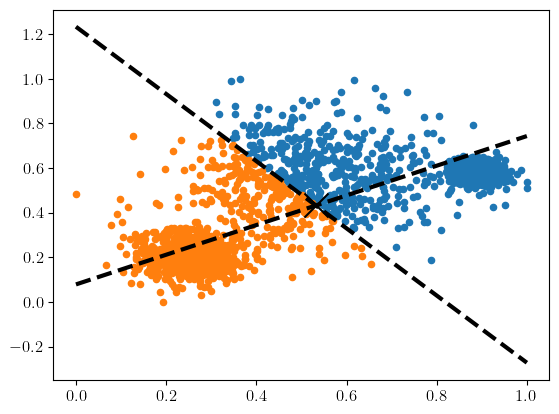

In [148]:
plt.scatter(data[left_mask,0], data[left_mask,1], s = 20)
plt.scatter(data[right_mask,0], data[right_mask,1], s = 20)
plt.plot(np.linspace(0,1,10), line, c = 'k', linestyle = '--', linewidth = 3)
plt.plot(np.linspace(0,1,10), perpendicular_line, c = 'k', linestyle = '--', linewidth = 3)
plt.scatter(midpoint[0], midpoint[1], marker = 'x', s = 300, c = 'k')

### IMM Baseline

In [16]:
imm_tree = ExTree(k, max_leaves = 3)
imm_labels = imm_tree.fit_predict(data, kmeans)

Text(0, 0.5, 'y')

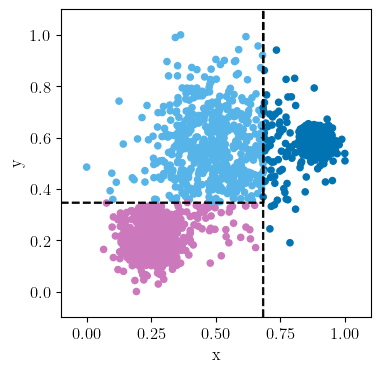

In [17]:
colorswitch = {0:2, 1:0, 2:1}
exkmc_labels_ = np.array([colorswitch[i] for i in exkmc_labels])

fig,ax = plt.subplots(figsize = (4,4), dpi = 100)
ax.scatter(data[:,0], data[:,1], c = imm_labels, cmap = cmap_subset, s = 20)
plot_decision_boundaries(imm_tree, data, ax = ax, resolution = 1000)
ax.set_xlabel('x')
ax.set_ylabel('y')
#plt.savefig('figures/example_imm.jpg', bbox_inches = 'tight', dpi = 300)

### Random Tree Baseline

In [ ]:
# Svensson Random Tree for comparison:
random_tree_cost = np.inf
for i in range(10000):
    random_tree = RandomTree(max_leaf_nodes = k, min_points_leaf = 1)
    random_tree.fit(kmeans.cluster_centers_)
    random_tree_labels = random_tree.predict(data)
    rcost = kmeans_cost(data, labels_to_clustering(random_tree_labels), kmeans.cluster_centers_)
    if rcost < random_tree_cost:
        random_tree_cost = rcost

# Creating Rule sets

### Grid Partition

In [13]:
cells = 5
grid = rule_grid(data,cells)
# This actually does a clustering with cells x cells clusters just for visualization purposes
grid_rules = RuleClustering(grid, k_clusters = cells**2)
grid_rules.fit_rules(data)
grid_labels = grid_rules.predict(data)

AttributeError: 'RuleClustering' object has no attribute 'fit_rules'

Text(0, 0.5, 'y')

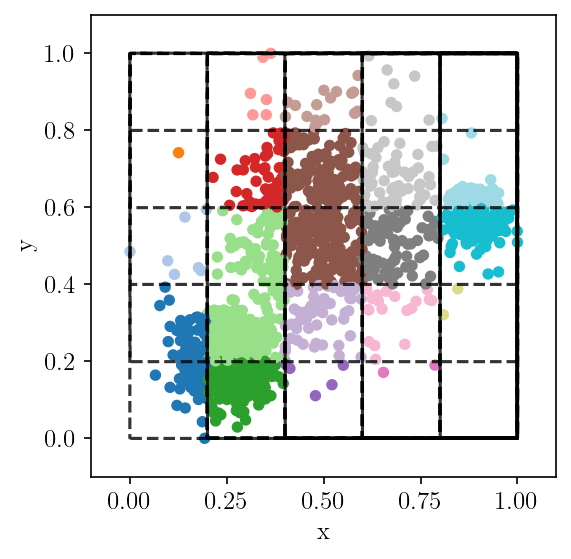

In [13]:
#scatter = plt.scatter(data2[select,0], data2[select,1])
fig,ax = plt.subplots(figsize = (4,4), dpi = 150)
ax.scatter(data[:,0], data[:,1], c = grid_labels, cmap = 'tab20', s = 20)
plot_decision_boundaries(grid_rules, data, ax = ax, resolution = 1000)
ax.set_xlabel('x')
ax.set_ylabel('y')

### k-Means Tree Partition

In [43]:
kmeans_tree = CentroidTree(max_leaf_nodes = 64, max_depth = 2, min_points_leaf = 1, norm = 2, center_init = 'manual', centers = kmeans.cluster_centers_)
kmeans_tree.fit(data)
kmeans_tree_labels = kmeans_tree.predict(data)

Text(0, 0.5, 'y')

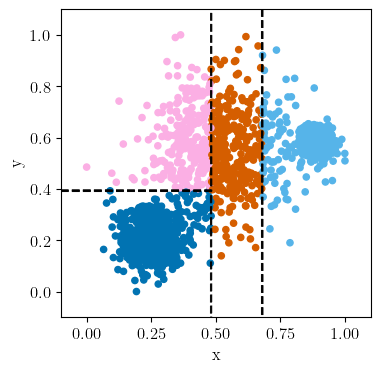

In [44]:
fig,ax = plt.subplots(figsize = (4,4), dpi = 100)
scatter = ax.scatter(data[:,0], data[:,1], c = kmeans_tree_labels, cmap = cmap, s = 20)
plot_decision_boundaries(kmeans_tree, data, ax = ax, resolution = 1000)
ax.set_xlabel('x')
ax.set_ylabel('y')
#plt.savefig('figures/example_kmeans_tree.jpg', bbox_inches = 'tight', dpi = 300)

In [17]:
#visualize_tree(kmeans_tree.root, feature_labels = ['x', 'y'])

### k-Medians Tree Partition

In [22]:
kmedians_tree = CentroidTree(max_leaf_nodes = 6, min_points_leaf = 1, norm = 1, center_init = 'manual', centers = kmeans.cluster_centers_)
kmedians_tree.fit(data)
kmedians_tree_labels = kmedians_tree.predict(data)

Text(0, 0.5, 'y')

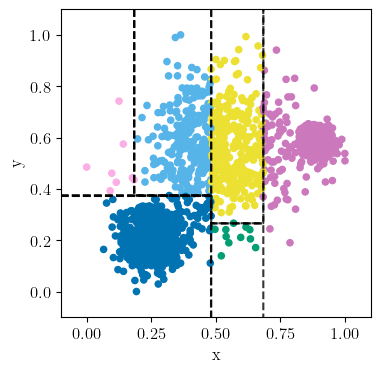

In [23]:
fig,ax = plt.subplots(figsize = (4,4), dpi = 100)
scatter = ax.scatter(data[:,0], data[:,1], c = kmedians_tree_labels, cmap = cmap, s = 20)
plot_decision_boundaries(kmedians_tree, data, ax = ax, resolution = 1000)
ax.set_xlabel('x')
ax.set_ylabel('y')

### ExKMC Tree

In [42]:
# ExKMC
ExKMC_tree = ExTree(k, max_leaves = 64, max_depth = 3, base_tree='NONE')
exkmc_labels = ExKMC_tree.fit_predict(data, kmeans)
exkmc_tree = ConvertExKMC(ExKMC_tree.tree, data)
exkmc_tree_labels = exkmc_tree.predict(data)

TypeError: __init__() got an unexpected keyword argument 'max_depth'

Text(0, 0.5, 'y')

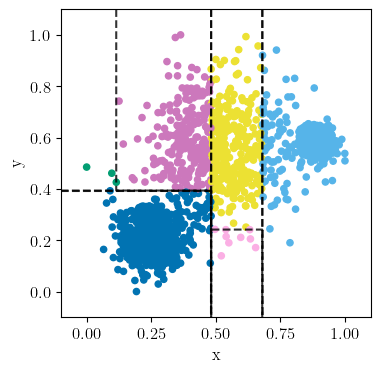

In [25]:
fig,ax = plt.subplots(figsize = (4,4), dpi = 100)
scatter = ax.scatter(data[:,0], data[:,1], c = exkmc_tree_labels, cmap = cmap, s = 20)
plot_decision_boundaries(exkmc_tree, data, ax = ax, resolution = 1000)
ax.set_xlabel('x')
ax.set_ylabel('y')

### CART

In [40]:
k_ = 6
kmeans_extend = KMeans(n_clusters=k, random_state=seed).fit(data)
dtree = DecisionTreeClassifier(criterion='entropy', max_leaf_nodes = 32, max_depth = 3)
dtree.fit(data, kmeans_extend.labels_)
kmeans_dtree = ConvertSklearn(dtree.tree_, data)
kmeans_dtree_labels = kmeans_dtree.predict(data)

Text(0, 0.5, 'y')

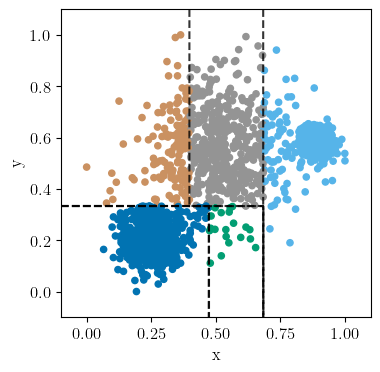

In [41]:
fig,ax = plt.subplots(figsize = (4,4), dpi = 100)
scatter = ax.scatter(data[:,0], data[:,1], c = kmeans_dtree_labels, cmap = cmap, s = 20)
plot_decision_boundaries(kmeans_dtree, data, ax = ax, resolution = 1000)
ax.set_xlabel('x')
ax.set_ylabel('y')

### Oblique Tree

In [28]:
obtree = CentroidTree(splits = 'oblique', max_leaf_nodes = 6, min_points_leaf = 1, norm = 2, center_init = 'manual', centers = kmeans.cluster_centers_)
obtree.fit(data)
obtree_labels = obtree.predict(data)

Text(0, 0.5, 'y')

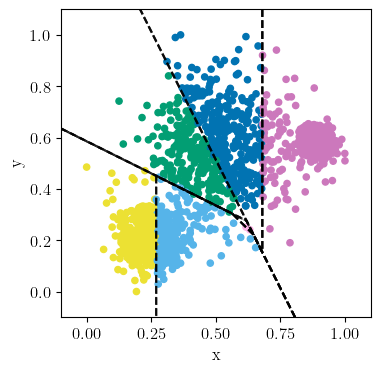

In [29]:
fig,ax = plt.subplots(figsize = (4,4), dpi = 100)
scatter = ax.scatter(data[:,0], data[:,1], c = obtree.predict(data), cmap = cmap, s = 20)
plot_decision_boundaries(obtree, data, ax = ax, resolution = 1000)
ax.set_xlabel('x')
ax.set_ylabel('y')

# Rule Clustering

### 1. Rule k-Means

In [31]:
rules = obtree
rule_kmeans = KMeansRuleClustering(rules, k_clusters = k, init = 'manual', center_init = kmeans.cluster_centers_)
rule_kmeans.fit(data)
rule_labels = rule_kmeans.labels
rule_kmeans_labels = rule_kmeans.predict(data)

In [34]:
rule_labels

array([2., 2., 0., 2., 1., 1.])

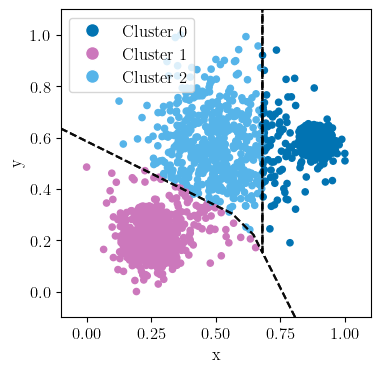

In [32]:
#plt.scatter(rule_kmeans.centers[:,0], rule_kmeans.centers[:,1], color = 'k', marker = 'x', s = 100)
colorswitch = {0:1, 1:0, 2:2}
rule_kmeans_labels_ = np.array([colorswitch[i] for i in rule_kmeans_labels])

fig,ax = plt.subplots(figsize = (4,4), dpi = 100)
scatter = ax.scatter(data[:,0], data[:,1], c = rule_kmeans_labels, cmap = cmap_subset, s = 20)
plot_decision_boundaries(rule_kmeans, data, ax = ax, resolution = 1000)

unique_labels = np.unique(rule_kmeans_labels)
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=scatter.cmap(scatter.norm(label)), markersize=10, label=f'Cluster {int(label)}') 
           if label != -1 else plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=scatter.cmap(scatter.norm(label)), markersize=10, label='Unclustered') 
        for label in unique_labels]

ax.set_xlabel('x')
ax.set_ylabel('y')
plt.legend(handles=handles, loc = 'upper left')
#plt.savefig('figures/example_rule_cluster.jpg', bbox_inches = 'tight', dpi = 300)

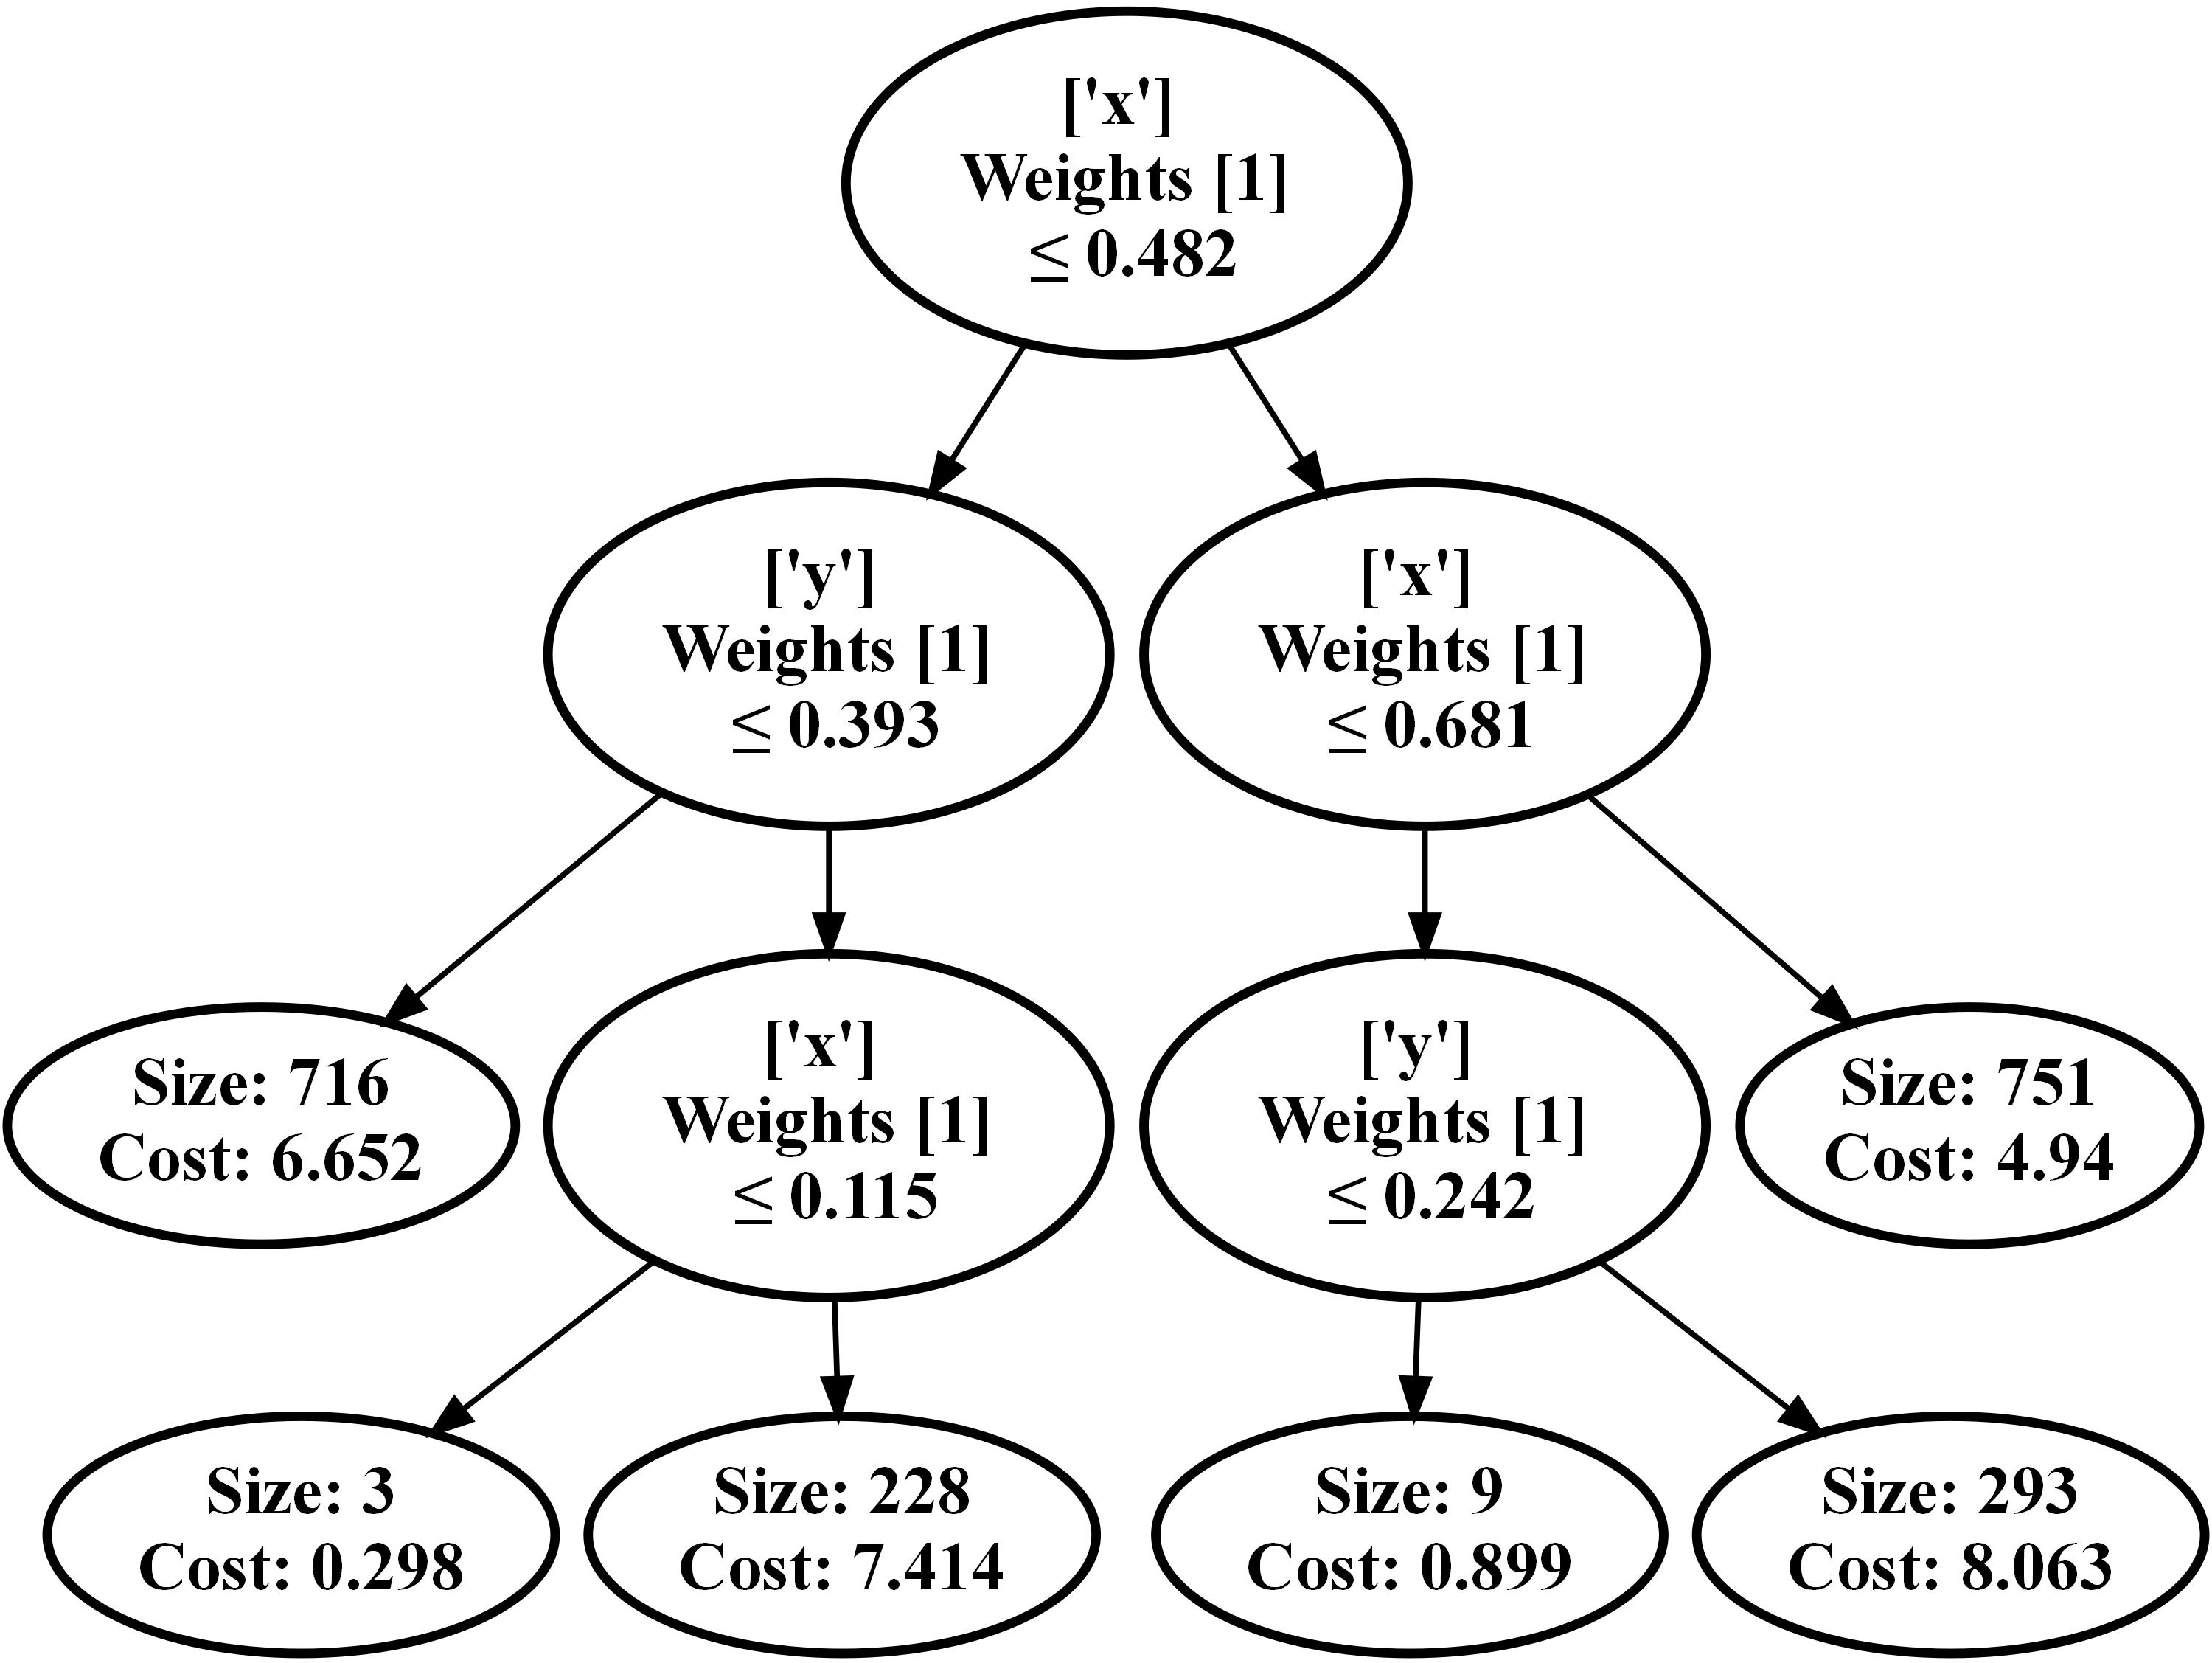

In [36]:
#rule_labels_ = [colorswitch[i] for i in rule_labels]
#leaf_colors = {leaf_node_labels[i]:mcolors.rgb2hex(cmap_subset(rule_labels_[i]), keep_alpha=True) for i in range(len(leaf_node_labels))}
visualize_tree(kmeans_tree.root, output_file = 'figures/spam.jpg', feature_labels = ['x', 'y'], leaf_colors = None, newline = False)

### 2. k-Medians

In [37]:
rules = kmedians_tree
rule_kmedians = KMediansRuleClustering(rules, k_clusters = k, init = 'random++', n_init = 10)
rule_kmedians.fit(data)
rule_kmedians_labels = rule_kmedians.predict(data)

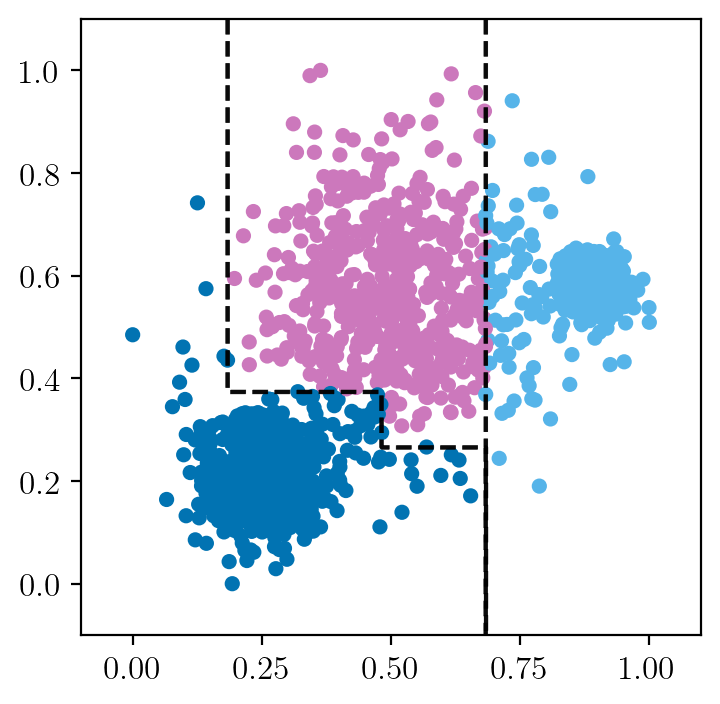

In [38]:
#plt.scatter(rule_kmeans.centers[:,0], rule_kmeans.centers[:,1], color = 'k', marker = 'x', s = 100)
colorswitch = {0:1, 1:0, 2:2}
rule_kmedians_labels_ = np.array([colorswitch[i] for i in rule_kmedians_labels])

fig,ax = plt.subplots(figsize = (4,4), dpi = 200)
scatter = ax.scatter(data[:,0], data[:,1], c = rule_kmedians_labels, cmap = cmap_subset, s = 20)
plot_decision_boundaries(rule_kmedians, data, ax = ax, resolution = 1000)

# Cost Comparison

In [30]:
# Revert the seed in case it has been advanced anywhere else:
np.random.seed(seed)

# Random centers to use:
plus_plus_centers = kmeans_plus_plus_initialization(data, k)

# Rule Clustering algorithm to use:
Clusterer = KMeansRuleClustering

min_leaves = k
max_leaves = 32
leaves = list(range(min_leaves,max_leaves))

# Define some models to be iteratively built (instead of re-computing them from scratch every iteration)
unsupervised_tree_ = UnsupervisedTree(splits = 'axis', max_leaf_nodes = max_leaves, norm = 2)
# Here we initialize a tree, which will expand later
unsupervised_tree_.fit(data, iterative = True, init_steps = k - 1)

unsupervised_oblique_tree_ = UnsupervisedTree(splits = 'oblique', max_leaf_nodes = max_leaves, norm = 2)
unsupervised_oblique_tree_.fit(data, iterative = True, init_steps = k - 1)

# This should be equivalent to ExKMC (if ExKMC doesn't use IMM base)
centroid_tree_ = CentroidTree(splits = 'axis', max_leaf_nodes = max_leaves, norm = 2, center_init = 'manual', centers = kmeans.cluster_centers_)
centroid_tree_.fit(data, iterative = True, init_steps = k - 1)

centroid_oblique_tree_ = CentroidTree(splits = 'oblique', max_leaf_nodes = max_leaves, norm = 2, center_init = 'manual', centers = kmeans.cluster_centers_)
centroid_oblique_tree_.fit(data, iterative = True, init_steps = k - 1)

clustered_tree_ = RuleClusteredTree(splits = 'axis', max_leaf_nodes = max_leaves, norm = 2, center_init = 'manual', centers = kmeans.cluster_centers_,
                                   clusterer = Clusterer)
clustered_tree_.fit(data, iterative = True, init_steps = k - 1)

clustered_tree_random = RuleClusteredTree(splits = 'axis', max_leaf_nodes = max_leaves, norm = 2, center_init = 'manual', centers = plus_plus_centers,
                                   clusterer = Clusterer)
clustered_tree_random.fit(data, iterative = True, init_steps = k - 1)

clustered_oblique_tree_ = RuleClusteredTree(splits = 'oblique', max_leaf_nodes = max_leaves, norm = 2, center_init = 'manual', centers = plus_plus_centers,
                                   clusterer = Clusterer)
clustered_oblique_tree_.fit(data, iterative = True, init_steps = k - 1)

clustered_oblique_tree_random = RuleClusteredTree(splits = 'oblique', max_leaf_nodes = max_leaves, norm = 2, center_init = 'manual', centers = plus_plus_centers,
                                   clusterer = Clusterer)
clustered_oblique_tree_random.fit(data, iterative = True, init_steps = k - 1)


# Track cost by leaves:
exkmc_costs = []
rule_exkmc_costs = []
rule_cart_costs =[]

rule_unsupervised_costs = []
rule_unsupervised_oblique_costs = []
rule_centroid_costs = []
rule_centroid_oblique_costs = []
rule_clustered_costs = []
rule_clustered_oblique_costs = []
rule_clustered_random_costs = []
rule_clustered_oblique_random_costs = []

# Expand the trees and compute cost:
for l in leaves:
    print("iteration: " + str(l))
    # ExKMC
    ExKMC_tree_ = ExTree(k, max_leaves = l, base_tree = "NONE")
    exkmc_labs_ = ExKMC_tree_.fit_predict(data, kmeans)
    exkmc_clustering_ = labels_to_clustering(exkmc_labs_)
    exkmc_centers_ = ExKMC_tree_.all_centers
    exkmc_cost_ = kmeans_cost(data, exkmc_clustering_, exkmc_centers_)
    exkmc_costs.append(exkmc_cost_)

    # Rule ExKMC
    exkmc_tree_ = ConvertExKMC(ExKMC_tree_.tree, data)
    rule_exkmc_ = Clusterer(exkmc_tree_, k_clusters = k, init = 'manual', center_init = kmeans.cluster_centers_,)
    rule_exkmc_.fit(data)
    data_clustering_exkmc_, data_labels_exkmc_ = rule_exkmc_.predict(data, return_clustering = True)
    rule_exkmc_costs.append(rule_exkmc_.cost)
    #rule_exkmc_iterations.append(rule_exkmc_.iterations)

    # Rule CART:
    kmeans_extend_ = KMeans(n_clusters=k, random_state=seed).fit(data)
    dtree_ = DecisionTreeClassifier(criterion='entropy', max_leaf_nodes = l)
    dtree_.fit(data, kmeans_extend_.labels_)
    kmeans_dtree_ = ConvertSklearn(dtree_.tree_, data)

    rule_cart_ = Clusterer(kmeans_dtree_, k_clusters = k, init = 'manual', center_init = kmeans.cluster_centers_)
    rule_cart_.fit(data)
    rule_cart_costs.append(rule_cart_.cost)
    #rule_cart_iterations.append(rule_cart_.iterations)
    
    # Rule Clustering for Unsupervised Tree
    unsupervised_tree_.fit_step()
    rule_kmeans_ = Clusterer(unsupervised_tree_, k_clusters = k, init = 'manual', center_init = kmeans.cluster_centers_, random_seed = seed)
    rule_kmeans_.fit(data, fit_rules = False)
    rule_unsupervised_costs.append(rule_kmeans_.cost)
    #rule_kmeans_iterations.append(rule_kmeans_.iterations)

    # Rule Clustering for Unsupervised Oblique Tree
    unsupervised_oblique_tree_.fit_step()
    rule_kmeans_ = Clusterer(unsupervised_oblique_tree_, k_clusters = k, init = 'manual', center_init = kmeans.cluster_centers_, random_seed = seed)
    rule_kmeans_.fit(data, fit_rules = False)
    rule_unsupervised_oblique_costs.append(rule_kmeans_.cost)
    #rule_kmeans_iterations.append(rule_kmeans_.iterations)


    # Rule Clustering for Centroid Tree
    centroid_tree_.fit_step()
    rule_kmeans_ = Clusterer(centroid_tree_, k_clusters = k, init = 'manual', center_init = centroid_tree_.centers, random_seed = seed)
    rule_kmeans_.fit(data, fit_rules = False)
    rule_centroid_costs.append(rule_kmeans_.cost)
    #rule_kmeans_iterations.append(rule_kmeans_.iterations)

    # Rule Clustering for Centroid Oblique Tree
    centroid_oblique_tree_.fit_step()
    rule_kmeans_ = Clusterer(centroid_oblique_tree_, k_clusters = k, init = 'manual', center_init = centroid_oblique_tree_.centers, random_seed = seed)
    rule_kmeans_.fit(data, fit_rules = False)
    rule_centroid_oblique_costs.append(rule_kmeans_.cost)
    #rule_kmeans_iterations.append(rule_kmeans_.iterations)

    # Clustered Tree
    clustered_tree_.fit_step()
    rule_clustered_costs.append(clustered_tree_.clustering_cost)
    #rule_kmeans_iterations.append(rule_kmeans_.iterations)

    # Clustered Oblique Tree
    clustered_oblique_tree_.fit_step()
    rule_clustered_oblique_costs.append(clustered_oblique_tree_.clustering_cost)
    #rule_kmeans_iterations.append(rule_kmeans_.iterations)

    # Random Initialization Clustered Tree
    clustered_tree_random.fit_step()
    rule_clustered_random_costs.append(clustered_tree_random.clustering_cost)
    #rule_kmeans_iterations.append(rule_kmeans_.iterations)

    # Random Initialization Clustered Oblique Tree
    clustered_oblique_tree_random.fit_step()
    rule_clustered_oblique_random_costs.append(clustered_oblique_tree_random.clustering_cost)
    #rule_kmeans_iterations.append(rule_kmeans_.iterations)

iteration: 3
iteration: 4
iteration: 5
iteration: 6
iteration: 7
iteration: 8
iteration: 9
iteration: 10
iteration: 11
iteration: 12
iteration: 13
iteration: 14
iteration: 15
iteration: 16
iteration: 17
iteration: 18
iteration: 19
iteration: 20
iteration: 21
iteration: 22
iteration: 23
iteration: 24
iteration: 25
iteration: 26
iteration: 27
iteration: 28
iteration: 29
iteration: 30
iteration: 31


In [ ]:
'''
# Rule Grid KMeans
rule_kmeans_2 = KMeansRuleClustering(grid, k_clusters = k, init = 'k-means')
rule_kmeans_2.fit(data)
rule_kmeans_labs2 = rule_kmeans_2.predict(data)

rule_grid_cost = kmeans_cost(data, labels_to_clustering(rule_kmeans_labs2), rule_kmeans_2.centers)
'''

Text(0, 0.5, 'Cost')

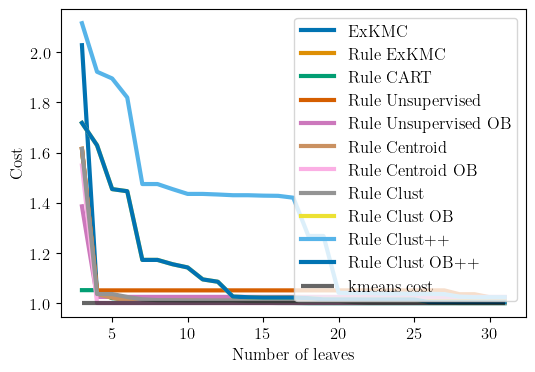

In [34]:
fig,ax = plt.subplots(figsize = (6,4))

ax.plot(leaves, np.array(exkmc_costs)/cost, linewidth = 3, label = 'ExKMC', c = cmap(0))
ax.plot(leaves, np.array(rule_exkmc_costs)/cost, linewidth = 3, label = 'Rule ExKMC', c = cmap(1))
ax.plot(leaves, np.array(rule_cart_costs)/cost, linewidth = 3, label = 'Rule CART', c = cmap(2))
ax.plot(leaves, np.array(rule_unsupervised_costs)/cost, linewidth = 3, label = 'Rule Unsupervised', c = cmap(3))
ax.plot(leaves, np.array(rule_unsupervised_oblique_costs)/cost, linewidth = 3, label = 'Rule Unsupervised OB', c = cmap(4))
ax.plot(leaves, np.array(rule_centroid_costs)/cost, linewidth = 3, label = 'Rule Centroid', c = cmap(5))
ax.plot(leaves, np.array(rule_centroid_oblique_costs)/cost, linewidth = 3, label = 'Rule Centroid OB', c = cmap(6))

ax.plot(leaves, np.array(rule_clustered_costs)/cost, linewidth = 3, label = 'Rule Clust', c = cmap(7))
ax.plot(leaves, np.array(rule_clustered_oblique_costs)/cost, linewidth = 3, label = 'Rule Clust OB', c = cmap(8))

ax.plot(leaves, np.array(rule_clustered_random_costs)/cost, linewidth = 3, label = 'Rule Clust++', c = cmap(9))
ax.plot(leaves, np.array(rule_clustered_oblique_random_costs)/cost, linewidth = 3, label = 'Rule Clust OB++', c = cmap(0))

#ax.hlines(random_tree_cost/cost, xmin = leaves[0], xmax = leaves[-1], color = 'k', linestyle = 'dotted', label = 'Random Tree', linewidth = 3, alpha = 0.6)
#ax.hlines(imm_cost/cost, xmin = leaves[0], xmax = leaves[-1], color = 'k', linestyle = '--', label = 'IMM Tree', linewidth = 3, alpha = 0.6)
ax.hlines(cost/cost, xmin = leaves[0], xmax = leaves[-1], color = 'k', linestyle = '-', label = 'kmeans cost', linewidth = 3, alpha = 0.6)

plt.legend(loc = 'upper right')
ax.set_xlabel('Number of leaves')
ax.set_ylabel('Cost')

# Dataset Demonstration

In [77]:
n_samples = 500
seed = 30
noisy_circles = datasets.make_circles(
    n_samples=n_samples, factor=0.5, noise=0.05, random_state=seed
)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=0.05, random_state=seed)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=seed)
rng = np.random.RandomState(seed)
no_structure = rng.rand(n_samples, 2), np.zeros(n_samples)

# Anisotropicly distributed data
random_state = 170
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

# blobs with varied variances
varied = datasets.make_blobs(
    n_samples=n_samples, cluster_std=[1.0, 2.5, 0.5], random_state=random_state
)

dataset_list = [noisy_circles, noisy_moons, blobs, aniso, varied, no_structure]

C:\Users\kq146\AppData\Local\Temp\ipykernel_28892\3927023097.py:97: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


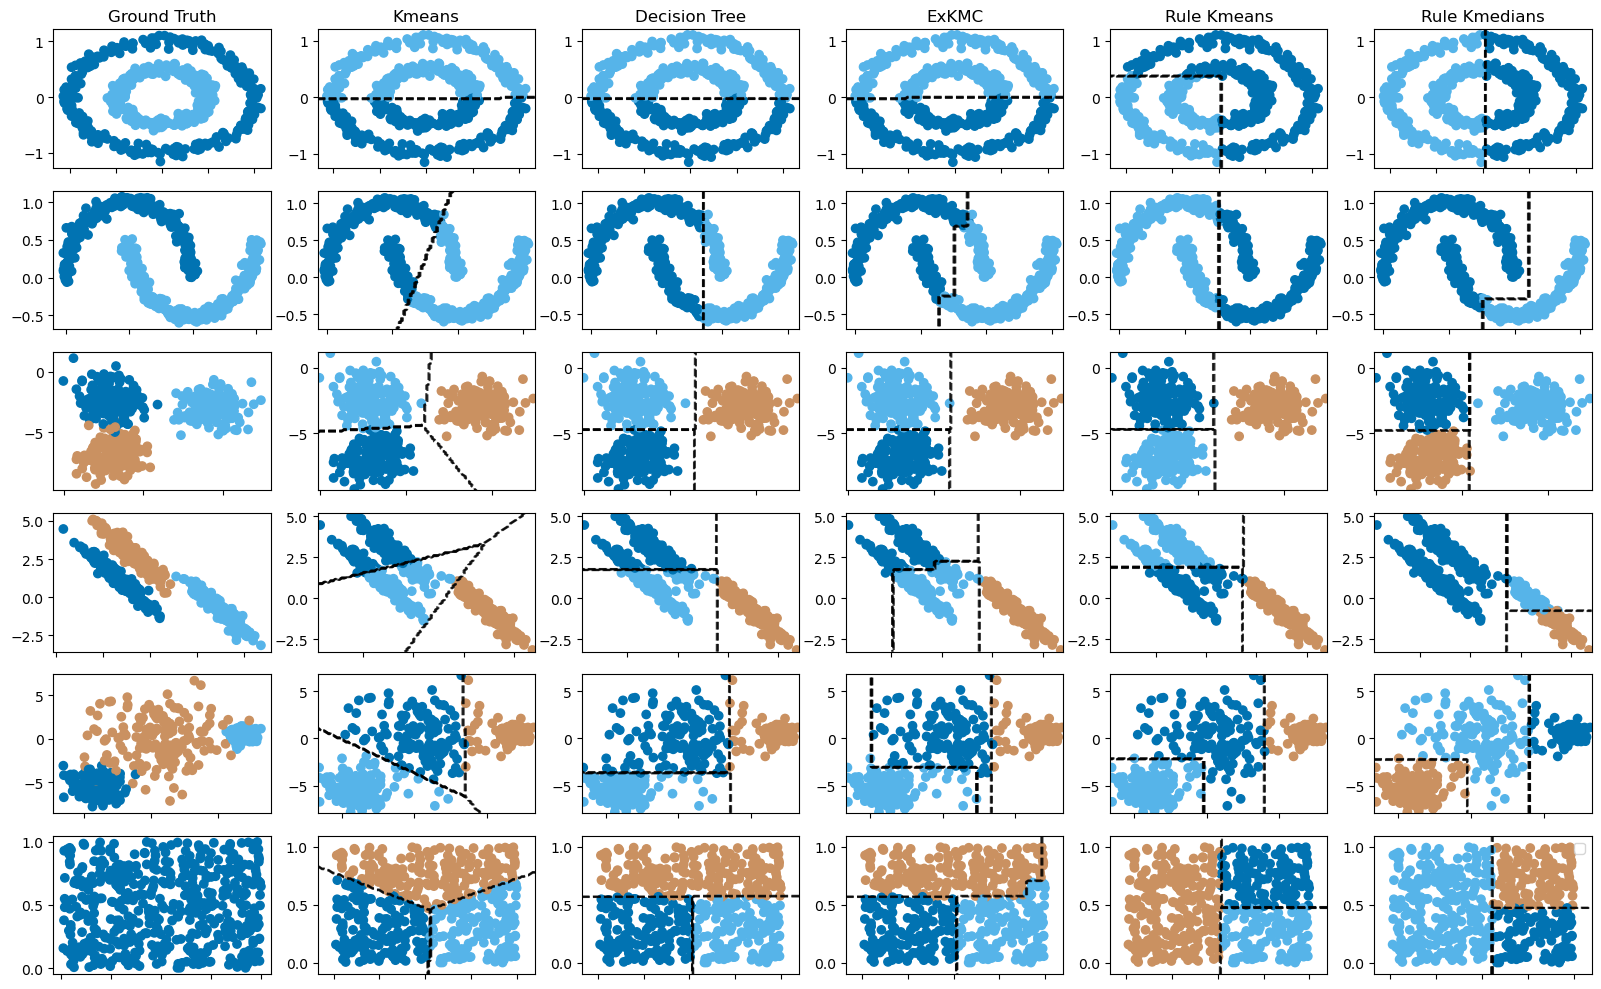

In [78]:
# Cluster and display Results
fig,axes = plt.subplots(6,6, figsize = (16,10))

# For each of the datasets do clusters
for d in range(len(dataset_list)):
    # Set titles
    if d == 0:
        axes[d,0].set_title('Ground Truth')
        axes[d,1].set_title('Kmeans')
        axes[d,2].set_title('Decision Tree')
        axes[d,3].set_title('ExKMC')
        axes[d,4].set_title('Rule Kmeans')
        axes[d,5].set_title('Rule Kmedians')
        #axes[d,5].set_title('Rule Agglomerative')
    
    X,y = dataset_list[d]

    # determine the number of clusters
    if np.sum(y) == 0:
        n_clusters = 3
    else:
        n_clusters = len(np.unique(y))

    # Baseline:
    axes[d,0].scatter(X[:,0], X[:,1], c = y, cmap = cmap)
    axes[d,0].set_xticklabels([])

    # Kmeans:
    kmeans = KMeans(n_clusters=n_clusters, random_state=39, n_init="auto").fit(X)
    axes[d,1].scatter(X[:,0], X[:,1], c = kmeans.labels_, cmap = cmap)
    plot_decision_boundaries(kmeans, X, ax = axes[d,1])
    axes[d,1].set_xticklabels([])

    # Decision tree
    tree = DecisionTreeClassifier(criterion = 'entropy', max_leaf_nodes = n_clusters).fit(X, kmeans.labels_)
    tree_labels = tree.predict(X)
    axes[d,2].scatter(X[:,0], X[:,1], c = tree_labels, cmap = cmap)
    plot_decision_boundaries(tree, X, ax = axes[d,2])
    axes[d,2].set_xticklabels([])

    # ExKMC
    ExKMC_tree = ExTree(n_clusters, max_leaves = 6)
    exkmc_labels = ExKMC_tree.fit_predict(X, kmeans)
    axes[d,3].scatter(X[:,0], X[:,1], c = exkmc_labels, cmap = cmap)
    plot_decision_boundaries(ExKMC_tree, X, ax = axes[d,3])
    axes[d,3].set_xticklabels([])

    # Rule K-means
    kmeans_tree = KMeansTree(max_leaf_nodes = 6, min_points_leaf = 1)
    kmeans_tree.fit(X)
    kmeans_rules = tree_to_rules().traverse(kmeans_tree.root)
    rule_kmeans = KMeansRuleClustering(kmeans_rules, k_clusters = n_clusters, init = 'k-means', max_iterations = 500)
    rule_kmeans.fit(X)
    rule_kmeans_labels = rule_kmeans.predict(X)
    
    axes[d,4].scatter(X[:,0], X[:,1], c = rule_kmeans_labels, cmap = cmap)
    plot_decision_boundaries(rule_kmeans, X, ax = axes[d,4])
    axes[d,4].set_xticklabels([])

    # Rule k-Medians
    kmedians_tree = KMediansTree(max_leaf_nodes = 6, min_points_leaf = 1)
    kmedians_tree.fit(X)
    kmedians_rules = tree_to_rules().traverse(kmedians_tree.root)
    rule_kmedians = KMediansRuleClustering(kmedians_rules, k_clusters = n_clusters, init = 'k-medians', max_iterations = 500)
    rule_kmedians.fit(X)
    rule_kmedians_labels = rule_kmedians.predict(X)
    axes[d,5].scatter(X[:,0], X[:,1], c = rule_kmedians_labels, cmap = cmap)
    plot_decision_boundaries(rule_kmedians, X, ax = axes[d,5])
    axes[d,5].set_xticklabels([])

    # Rule Agglomerative:
    '''
    D_single = compute_distance_matrix(X, kmeans_rules, rule_single_linkage_distance)
    AggCluster = AgglomerativeRuleClustering(kmeans_rules, k_clusters = 4, linkage = 'single')
    AggCluster.fit(X, D_single)
    AggCluster_labels = AggCluster.predict(X)
    
    axes[d,5].scatter(X[:,0], X[:,1], c = AggCluster_labels)
    plot_decision_boundaries(AggCluster, X, ax = axes[d,5])
    unique_labels = np.unique(AggCluster_labels)
    handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=scatter.cmap(scatter.norm(label)), markersize=10, label='Unclustered') for label in unique_labels if label == -1]
    axes[d,5].legend(handles=handles)
    axes[d,5].set_xticklabels([])
    '''
        

# Loop through each subplot
for i, ax in enumerate(axes.flat):
    #ax.plot(x, y)
    
    # Hide x-axis labels for all subplots except those in the last row
    if i < 5 * 5:  # If the subplot is not in the last row
        ax.set_xticklabels([])

# Adjust the layout
plt.tight_layout()
plt.legend()